# 0. Importing Dependencies

***

In [2]:
!pip install numpy==1.24

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.8/19.8 MB 1.0 MB/s eta 0:00:0000:0100:010m
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.0
    Uninstalling numpy-2.0.0:
      Successfully uninstalled numpy-2.0.0


In [1]:
import sys
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import random

from tqdm import tqdm

from pprint import pprint

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

random.seed(42)

In [2]:
parent_dir = os.path.abspath("..")
sys.path.append(parent_dir + "/api_scraper")
import database
from database import StockData

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


# 1. Loading and Preparing Dataset

***

## 1.1 Retrieving Data From Database

***

In [4]:
def stockdata_to_tensor(x: StockData) -> torch.tensor:
    return torch.tensor(list(zip(*x)))

def stockdata_to_list(x: StockData):
    return list(zip(*x))

def partition_symbols(all_symbols: list[str]) -> tuple[list[str], list[str]]:
    """
    Randomly selects 80% of the symbols to be used for training
    Returns the sampled symbols (used for training) AND not-sampled symbols (used for evaluation)
    """
    sample_size = int(len(all_symbols) * 0.80)
    
    sample = random.sample(all_symbols, sample_size)
    non_sample = [x for x in all_symbols if x not in sample]
    
    return sample, non_sample

def get_data(symbols: list[str], start_date = None, end_date = None) -> torch.tensor:
    """
    Given a list of symbols, retrieves the stock data from the database
    and returns the data as a tensor.
    
    shape: [num_symbols, 490, num_features (currently 5)]
        TODO: more features such as MACD, EMA
    """
    data = []
    for symbol in tqdm(symbols, desc="Retrieving symbols"):
        try:
            stock_data = database.get_stock_data(symbol, start_date=start_date ,end_date=end_date)
            stock_data = stockdata_to_list(stock_data)
            data.append(stock_data)
        except:
            print(symbol)
            continue
    data = torch.tensor(data)
    
    return data

## 1.2 Normalizing and Rescaling Data

***

- The open and close prices are normalized into **log returns**:

    $R_i = \ln\left[\frac{p_{i}}{p_{i-1}}\right]$

    where $p_i$ is the price on the $i$ th day

- The high and low prices are normalized into a log relative multiple from the close prices:

    $H_i = \ln\left[\frac{H_i}{C_i}\right]$
    
    $L_i = \ln\left[\frac{L_i}{C_i}\right]$


In [5]:
def scale_data(data: torch.tensor) -> torch.tensor:
    """
    Within each stock's history, scale values
    to a relative (0,1) range
    """
    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_data = torch.empty_like(data)
    for i in range(len(data)):
        stock_data = data[i]
        scaled_stock = torch.tensor(scaler.fit_transform(stock_data), dtype=torch.float32)
        scaled_data[i] = scaled_stock
        
    return scaled_data

def convert_open_close_to_log_returns(data: torch.tensor) -> torch.tensor:
    """
    Normalizes the open and close data by mapping them to log returns:
    
    Return_t = ln(current_price / previous_price)
    """
    open_prices = data[:,:,0]
    close_prices = data[:,:,1]
    open_log_returns = torch.log(open_prices[:, 1:] / open_prices[:, :-1])
    close_log_returns = torch.log(close_prices[:, 1:] / close_prices[:, :-1])
    
    # Pad array in the front with 0
    # this is to maintain consistent shape
    open_log_returns = torch.nn.functional.pad(open_log_returns, (1,0), 'constant', 0)
    close_log_returns = torch.nn.functional.pad(close_log_returns, (1,0), 'constant', 0)
    
    data[:,:,0] = open_log_returns
    data[:,:,1] = close_log_returns
    
    return data
    
    
def convert_high_low_to_log_multiple(data: torch.tensor) -> torch.tensor:
    """
    Reshapes the high and low prices to log multiples relative to the closing price.
    
    high = ln(high / close)
    low = ln(low / close)
    """
    close_prices = data[:,:,1]
    high_prices = data[:,:,3]
    low_prices = data[:,:,2]
    high_log_multiples = torch.log(high_prices / close_prices)
    low_log_multiples = torch.log(low_prices / close_prices)
    
    data[:,:,3] = high_log_multiples
    data[:,:,2] = low_log_multiples
    
    return data
    
def transform_data(data: torch.tensor) -> torch.tensor:
    data = convert_high_low_to_log_multiple(data)
    data = convert_open_close_to_log_returns(data)
    
    return data[:,1:] # Remove the first day because of padding in first element from log returns
    

In [275]:
all_symbols = database.get_all_symbols()
sampled_symbols, not_sampled_symbols = partition_symbols(all_symbols)

# data = [stockdata_to_list(database.get_stock_data(x)) for x in all_symbols]
data = get_data(sampled_symbols, start_date=None, end_date="2023-07-15")

closing_prices = torch.clone(data[:,:,1])

normalized_data = transform_data(data)
    
print(f"Normalized data shape: {normalized_data.shape}")
print(f"Closing prices shape: {closing_prices.shape}")

Retrieving symbols: 100%|██████████| 152/152 [00:00<00:00, 286.71it/s]


Normalized data shape: torch.Size([152, 1006, 5])
Closing prices shape: torch.Size([152, 1007])


## 1.3 Creating Sequences and Labels

***

The data is converted into sequences of a given sequence length as well as their corresponding labels.

### 1.3.1 Sequences

For a specified `sequence_length`, the sequences comprise the shape: (`all_possible_sequences`, `sequence_length`, 5)

Note that all stocks' data are no longer distinguished from each other.

### 1.3.2 Labels

The labels are derived from the unnormalized closing prices data. 



In [6]:

# feature indexes (dim 2)
# 0: open
# 1: close
# 2: low
# 3: high
# 4: volume

class StockPriceDataset(Dataset):
    def __init__(self, normalized_data, closing_prices, seq_length):
        self.sequences = []
        self.labels = []
        self.sequence_length = seq_length
        for i in tqdm(range(len(normalized_data)), desc="Creating sequences"):
            seq, lbl = self._create_sequences(normalized_data[i], closing_prices[i], seq_length)
            self.sequences.append(seq)
            self.labels.append(lbl)
            
        self.sequences = np.concatenate(self.sequences, axis=0)
        self.labels = np.concatenate(self.labels, axis=0)
        
        
    def __len__(self):
        return len(self.sequences)
    
    
    def __getitem__(self, idx):
        return torch.tensor(self.sequences[idx], dtype=torch.float32), \
            torch.tensor(self.labels[idx], dtype=torch.float32)
            
            
    def _create_sequences(self, normalized_data, closing_prices, seq_length):
        """
        Creates sequences of length {time_steps},
        compiles them into an array that contains all possible
        contiguous sequences.
        """
        sequences = []
        labels = []
        for i in range(len(normalized_data) - seq_length):
            sequences.append(normalized_data[i: i+seq_length])
            latest_closing_price = closing_prices[i+seq_length]
            next_closing_price = closing_prices[i+seq_length+1]
            
            log_price_change = torch.log(next_closing_price / latest_closing_price)
            labels.append(log_price_change)
        sequences = np.array([x.numpy() for x in sequences])    # Convert inner tensors to numpy array first
        labels = np.array(labels)
        return sequences, labels
    

class CustomStockPriceDataset(StockPriceDataset):
    def __init__(self, sequences, labels):
        self.sequences = sequences
        self.labels = labels
    
    

In [257]:
dataset = StockPriceDataset(normalized_data, closing_prices, 14)
print(f"sequences shape: {dataset.sequences.shape}")
print(f"labels shape: {dataset.labels.shape}")

Creating sequences: 100%|██████████| 152/152 [00:03<00:00, 48.27it/s]


sequences shape: (150784, 14, 5)
labels shape: (150784,)


## 1.4 Scaling Volumes Within Each Sequence

***

Within each sequence, volumes are rescaled to a (0,1) scale.

In [7]:
def minmax_scale_volumes_within_sequences(sequences: np.ndarray):
    scaler = MinMaxScaler(feature_range=(0,1))
    for i in tqdm(range(len(sequences)), desc="Scaling volumes"):
        sequence_volumes = sequences[i, :, 4].reshape(-1, 1)
        scaled_volumes = scaler.fit_transform(sequence_volumes)
        sequences[i, :, 4] = scaled_volumes.flatten()
        
    return sequences

In [167]:
dataset.sequences = minmax_scale_volumes_within_sequences(dataset.sequences)

Scaling volumes: 100%|██████████| 150784/150784 [00:28<00:00, 5263.70it/s]


## 1.4 Data Split

***

In [8]:
def create_data_split(dataset):
    """
    Create a 70-20-10 train-val-test data split
    """

    train_sequences, val_sequences, train_labels, val_labels = train_test_split(
        dataset.sequences, dataset.labels, test_size=0.3, random_state=42
    )

    val_sequences, test_sequences, val_labels, test_labels = train_test_split(
        val_sequences, val_labels, test_size=0.33, random_state=42
    )
    
    return train_sequences, train_labels, val_sequences, val_labels, test_sequences, test_labels

In [46]:
train_sequences, train_labels, val_sequences, val_labels, test_sequences, test_labels = create_data_split(dataset)

print(f"Training sequences shape: {train_sequences.shape}")
print(f"Validation sequences shape: {val_sequences.shape}")
print(f"Test sequences shape: {test_sequences.shape}")
print()
print(f"Training labels shape: {train_labels.shape}")
print(f"Validation labels shape: {val_labels.shape}")
print(f"Test labels shape: {test_labels.shape}")

NameError: name 'dataset' is not defined

In [9]:
def create_dataloader(sequences, labels, batch_size):
    custom_dataset = CustomStockPriceDataset(sequences, labels)
    
    dataloader = DataLoader(custom_dataset, batch_size, shuffle=True)
    
    return dataloader

In [288]:
batch_size = 64

train_dataloader = create_dataloader(train_sequences, train_labels, batch_size)
val_dataloader = create_dataloader(val_sequences, val_labels, batch_size)
test_dataloader = create_dataloader(test_sequences, test_labels, batch_size)

## 1.5 Condensed Data Processing (Only Run This Function Below)

***

In [10]:
def get_processed_data(symbols: list[str], time_window, batch_size) -> tuple[DataLoader, DataLoader, DataLoader]: 
    """
    Condensed version of everything above into a single function.
    Returns DataLoaders for training, validation, and testing
    """
    # Get the raw data as a tesnor
    data = get_data(symbols, start_date=None, end_date="2023-07-01")
    closing_prices = torch.clone(data[:,:,1])
    
    # Scale the data to a (0, 1) within each column (field)
    normalized_data = transform_data(data)
    
    # Convert the scaled data into a dataset of sequences and their labels whose length is specified by {time_window}
    dataset = StockPriceDataset(normalized_data, closing_prices, time_window)
    
    dataset.sequences = minmax_scale_volumes_within_sequences(dataset.sequences)
    
    # Creates a split of these sequences and labels into a train-val-test split
    train_sequences, train_labels, val_sequences, val_labels, test_sequences, test_labels = create_data_split(dataset)
    
    # Turns these sequences and labels into dataloaders
    train_dataloader = create_dataloader(train_sequences, train_labels, batch_size)
    val_dataloader = create_dataloader(val_sequences, val_labels, batch_size)
    test_dataloader = create_dataloader(test_sequences, test_labels, batch_size)
    
    return train_dataloader, val_dataloader, test_dataloader
    

In [127]:
train_dataloader, val_dataloader, test_dataloader = get_processed_data(sampled_symbols, 14, 64)

Scaling volumes: 100%|██████████| 189088/189088 [00:37<00:00, 5097.96it/s]


# 2. Defining LSTM Model

***

In [11]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size, 
                            hidden_size=hidden_size,
                            num_layers=num_layers,
                            batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        out_last = lstm_out[:,-1,:]
        out = self.fc(out_last)
        
        return out

# 3. Model Training

## 3.1 Custom Directional Loss

Because of the idea that stocks generally increase over time (and since the data primarily consists of large cap stocks),the data lends itself to have a bias in positive changes in price. 

Therefore, it is ideal that the model can distinguish changes in direction.

A penalty multiplier is applied when the stock incorrectly predicts the direction of a stock. This is in addition to a given loss function.

In [12]:
class DirectionalLoss(nn.Module):
    def __init__(self, loss_fn):
        super(DirectionalLoss, self).__init__()
        self.loss_fn = loss_fn
        
    def forward(self, y_pred, y_true):
        incorrect_sign = y_pred * y_true < 0
        weight = torch.where(incorrect_sign, torch.tensor(2.0), torch.tensor(1.0))
        loss = weight * self.loss_fn(y_pred, y_true)
        return loss.mean()

In [24]:
def train_model(model, num_epochs, 
                train_loader, val_loader,
                optimizer, criterion,
                device):
    training_losses = []
    validation_losses = []
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        
        for sequences, targets in tqdm(train_loader, desc=f"Epoch {epoch} training", leave=False):
            optimizer.zero_grad()
            predictions = model(sequences)
            loss = criterion(predictions.squeeze(), targets)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5)
            optimizer.step()
            running_loss += loss.item()
            
        avg_train_loss = running_loss / len(train_loader)
        training_losses.append(avg_train_loss)
        
        model.eval()
        with torch.no_grad():
            running_loss_val = 0.0
            for sequences, targets in tqdm(val_loader, desc=f"Epoch {epoch} evaluating validation loss", leave=False):
                predictions = model(sequences)
                loss = criterion(predictions.squeeze(), targets)
                running_loss_val += loss.item()
            avg_val_loss = running_loss_val / len(val_loader)
            validation_losses.append(avg_val_loss)
            
            
        print(f"Epoch {epoch+1:>2} / {num_epochs} || Train Loss: {avg_train_loss:<30} || Validation Loss: {avg_val_loss:<30}")
    
    return training_losses, validation_losses
                

In [208]:
input_size = 5
hidden_size = 50
num_layers = 2
learning_rate = 0.001
num_epochs = 30

model = LSTMModel(input_size, hidden_size, num_layers)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, amsgrad=True)
# criterion = torch.nn.MSELoss()
criterion = DirectionalLoss(torch.nn.MSELoss())

In [209]:
training_losses, validation_losses = train_model(model, num_epochs=num_epochs, 
                                                 train_loader=train_dataloader, 
                                                 val_loader=val_dataloader, 
                                                 optimizer=optimizer, criterion=criterion
                                                 device=device)

Epoch  1 / 30 || Train Loss: 0.0009629790823215224          || Validation Loss: 0.00095999501262426           


Epoch  2 / 30 || Train Loss: 0.0009580435426588255          || Validation Loss: 0.0009725000111254537         


Epoch  3 / 30 || Train Loss: 0.0009466909944383201          || Validation Loss: 0.0009541952793922605         


Epoch  4 / 30 || Train Loss: 0.0009360068423010296          || Validation Loss: 0.0009399357358414193         


Epoch  5 / 30 || Train Loss: 0.0009207461706440275          || Validation Loss: 0.0009231396324434985         


Epoch  6 / 30 || Train Loss: 0.0009091037622772891          || Validation Loss: 0.0009214047881389501         


Epoch  7 / 30 || Train Loss: 0.0008963208067738874          || Validation Loss: 0.0009182768356018672         


Epoch  8 / 30 || Train Loss: 0.0008844598850136566          || Validation Loss: 0.0009000787362817357         


Epoch  9 / 30 || Train Loss: 0.000873282479967174           || Validation Loss: 0.0008987894560871567         


Epoch 10 / 30 || Train Loss: 0.0008691885389006612          || Validation Loss: 0.000878014780319677          


Epoch 11 / 30 || Train Loss: 0.0008560680374626607          || Validation Loss: 0.0008785473179113403         


Epoch 12 / 30 || Train Loss: 0.0008456878730618028          || Validation Loss: 0.0008629057757784357         


Epoch 13 / 30 || Train Loss: 0.0008369297105078162          || Validation Loss: 0.0008678071434230874         


Epoch 14 / 30 || Train Loss: 0.000828730463223165           || Validation Loss: 0.0008579694154133965         


Epoch 15 / 30 || Train Loss: 0.0008191451077547037          || Validation Loss: 0.0008374854811405339         


Epoch 16 / 30 || Train Loss: 0.0008114454956111414          || Validation Loss: 0.0008447664406839247         


Epoch 17 / 30 || Train Loss: 0.0008053649350415181          || Validation Loss: 0.0008722376339319299         


Epoch 18 / 30 || Train Loss: 0.0008013408080053826          || Validation Loss: 0.0008479277059319921         


Epoch 19 / 30 || Train Loss: 0.0007971700633502086          || Validation Loss: 0.0008479663995973853         


Epoch 20 / 30 || Train Loss: 0.0007906198620648039          || Validation Loss: 0.0008211751780516904         


Epoch 21 / 30 || Train Loss: 0.0007896995519739435          || Validation Loss: 0.0008187396881020263         


Epoch 22 / 30 || Train Loss: 0.0007846191142347049          || Validation Loss: 0.0008364465889665357         


Epoch 23 / 30 || Train Loss: 0.0007820954724747659          || Validation Loss: 0.0008346470800338447         


Epoch 24 / 30 || Train Loss: 0.0007787898086738124          || Validation Loss: 0.0008143085440771088         


Epoch 25 / 30 || Train Loss: 0.0007747137145964767          || Validation Loss: 0.0008367007582439581         


Epoch 26 / 30 || Train Loss: 0.0007701004189298008          || Validation Loss: 0.0008131575888319468         


Epoch 27 / 30 || Train Loss: 0.0007654601223343475          || Validation Loss: 0.0008405532368865524         


Epoch 28 / 30 || Train Loss: 0.0007606710703112185          || Validation Loss: 0.00080581470720523           


Epoch 29 / 30 || Train Loss: 0.0007558903136558718          || Validation Loss: 0.0008185596933749501         


Epoch 30 / 30 || Train Loss: 0.0007524457915728404          || Validation Loss: 0.0008158161348976659         


In [14]:
def plot_losses(training_losses, validation_losses):
    plt.clf()
    training_losses = torch.FloatTensor(training_losses)
    validation_losses = torch.FloatTensor(validation_losses)
    
    plt.plot(training_losses, label="Training")
    plt.plot(validation_losses, label="Validation")
    plt.legend(loc="upper right")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.show()

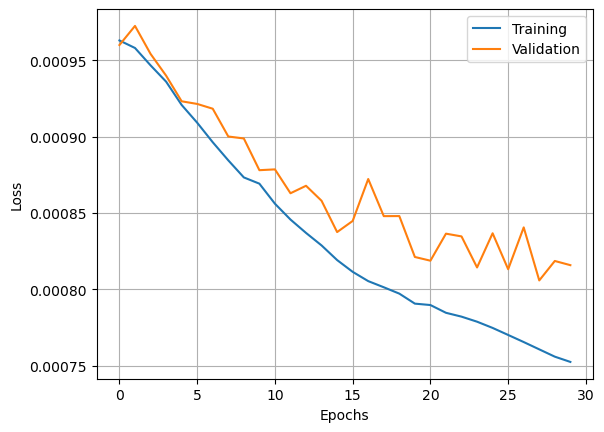

In [211]:
plot_losses(training_losses, validation_losses)

In [212]:
with torch.no_grad():
    running_test_loss = 0.0
    for sequences, targets in test_dataloader:
        predictions = model(sequences)
        loss = criterion(predictions.squeeze(), targets)
        running_test_loss += loss.item()
        
    avg_test_loss = running_test_loss / len(test_dataloader)
    
    print(avg_test_loss)

0.0007938348655101374


In [180]:
model_path = os.path.abspath(".") + "/model_14day.pt"
torch.save(model, model_path)

## 3.1. Model Loading

In [223]:
model = torch.load("model_14day.pt")

# 4. Model Evaluation

## 4.1 Preparing Input Data

In [15]:
def create_sequences(normalized_data, seq_length):
    """
    Creates sequences of length {time_steps},
    compiles them into an array that contains all possible
    contiguous sequences.
    """
    sequences = []
    for i in range(len(normalized_data) - seq_length+1):
        sequences.append(normalized_data[i: i+seq_length])
        
    sequences = np.array([x.numpy() for x in sequences])    # Convert inner tensors to numpy array first

    return sequences

In [16]:
def prepare_prediction_data(symbol: str, seq_length, start_date=None, end_date=None) -> StockPriceDataset:
    stock_data = database.get_stock_data(symbol, 
                                         fields=("open", "close", "high", "low", "volume"),
                                         start_date=start_date, 
                                         end_date=end_date)
    stock_closing_prices = stockdata_to_tensor(stock_data)[:,1]
    stock_data = stockdata_to_tensor(stock_data).unsqueeze(0)
    transformed_data = transform_data(stock_data)[0]
    sequences = create_sequences(transformed_data, seq_length)
    sequences = minmax_scale_volumes_within_sequences(sequences)
    
    # dataset = StockPriceDataset(stock_data, stock_closing_prices, seq_length)
    # dataset = minmax_scale_volumes_within_sequences(dataset)
    
    # return dataset, stock_closing_prices[0]
    return sequences, stock_closing_prices

## 4.2 Making Predictions and Plotting Results

In [40]:
def predict_stock(model: nn.Module, stock_name: str, seq_length: int, start=None, end=None, plot=True) -> None:
    sequences, stock_closing_prices = prepare_prediction_data(stock_name, seq_length, start, end)
    sequences = torch.tensor(sequences, dtype=torch.float32)
    
    predictions = get_predictions(model, sequences, stock_closing_prices)
    
    if plot:
        plot_predictions(stock_name, predictions, stock_closing_prices, seq_length)
    else:
        return predictions
    
def plot_predictions(stock_name, predictions, closing_prices, sequence_length):
    plt.clf()
    plt.plot(predictions, label="Predicted", linewidth=0.8)
    plt.plot(closing_prices[sequence_length:], label="Actual", linewidth=0.8)
    plt.legend(loc="upper left")
    plt.title(f"Stock predictions for {stock_name}")
    plt.ylabel(f"Price")
    plt.xlabel(f"Day")
    plt.grid(True)
    plt.show()

def get_predictions(model: nn.Module, sequences: torch.Tensor, closing_prices: torch.Tensor) -> torch.FloatTensor:
    predictions = []
    for i in range(sequences.shape[0]):
        sequence = sequences[i].unsqueeze(0)
        sequence_length = sequence.shape[1]
        model_output = model(sequence)
        
        latest_closing_price = closing_prices[i + sequence_length - 1]
        next_price_prediction = latest_closing_price * torch.exp(model_output)
        predictions.append(next_price_prediction)
        
    return torch.FloatTensor(predictions)

In [38]:
def evaluate_non_sampled_symbols(model: nn.Module, not_sampled_symbols: list[str], sequence_length, start=None, end=None) -> None:
    scaler = MinMaxScaler(feature_range=(0,1))

    fig, axis = plt.subplots(nrows=len(not_sampled_symbols), ncols=1, figsize=(8, 6*len(not_sampled_symbols)))

    for i, symbol in enumerate(not_sampled_symbols):
        predictions = predict_stock(model=model, stock_name=symbol, seq_length=sequence_length, 
                                    start=start, end=end, plot=False)
        stock_data = database.get_stock_data(symbol, 
                                             fields=("open", "close", "high", "low", "volume"),
                                             start_date=start, 
                                             end_date=end)
        stock_closing_prices = torch.FloatTensor(stock_data.close_price)
        
        axis[i].plot(predictions, label="Predicted", linewidth=0.8)
        axis[i].plot(stock_closing_prices[sequence_length:], label="Actual", linewidth=0.8)
        axis[i].legend(loc="upper left")
        axis[i].set_title(f"Actual vs. Predicted Prices for ${symbol}")
        axis[i].set_xlabel("Time")
        axis[i].set_ylabel("Stock Price")
        axis[i].grid(True)

    plt.show()

Scaling volumes: 100%|██████████| 25/25 [00:00<00:00, 2237.53it/s]


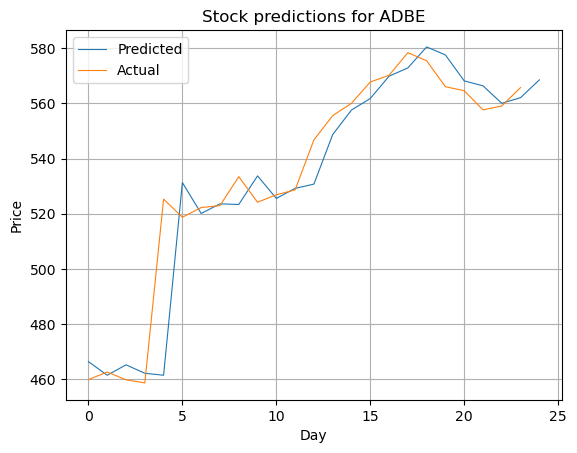

In [268]:
predict_stock(model, "ADBE", 14, start="2024-05-20", end="2024-07-15")

Scaling volumes: 100%|██████████| 121/121 [00:00<00:00, 3705.84it/s]


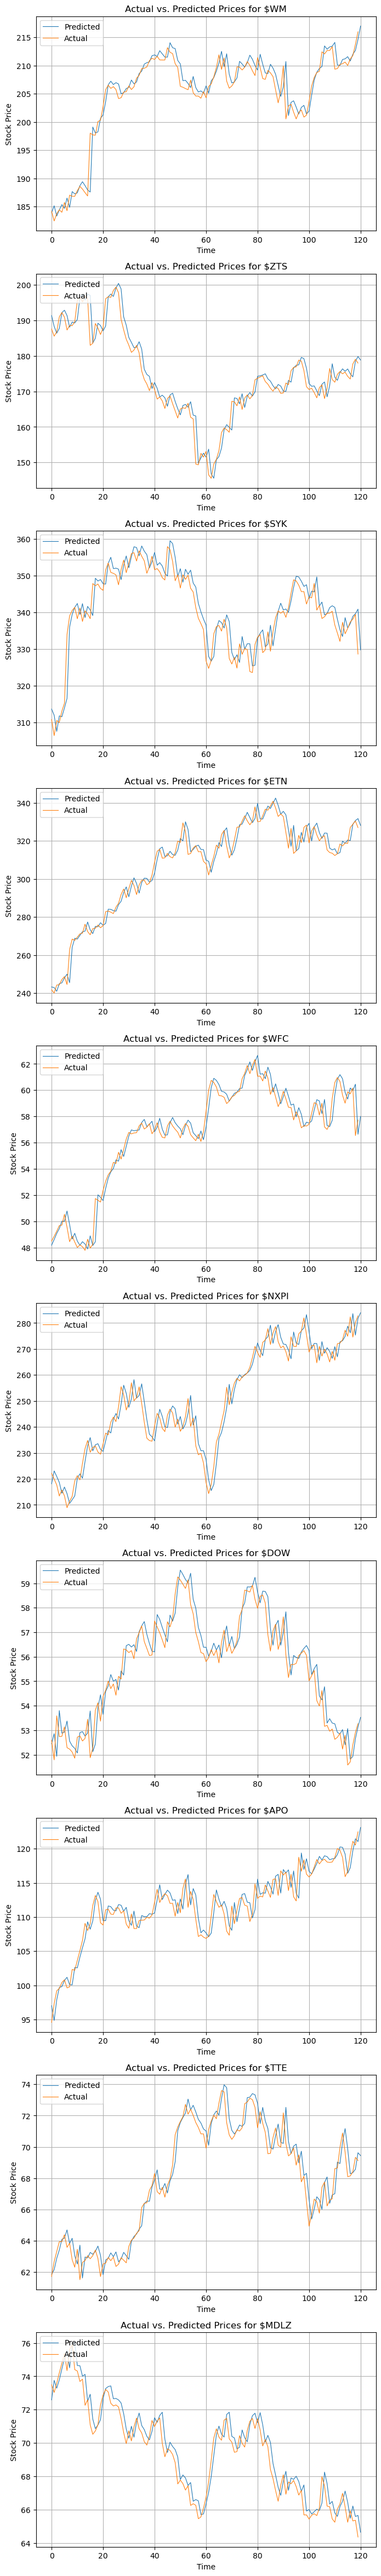

In [248]:
evaluate_non_sampled_symbols(model, random.sample(not_sampled_symbols, 10), 14, start='2024-01-01', end='2024-07-15')

# 5. Additional Models
***

### 5.1 Larger Time Window (60 days)

In [26]:
input_size = 5
hidden_size = 50
num_layers = 2
LR = 0.003
BATCH_SIZE = 128

model_60day = LSTMModel(input_size, hidden_size, num_layers)
optimizer = optim.AdamW(model_60day.parameters(), lr=LR, amsgrad=True)
criterion = nn.SmoothL1Loss()

In [30]:
all_symbols = database.get_all_symbols()
random.seed(50)
sampled_symbols, not_sampled_symbols = partition_symbols(all_symbols)
train_dataloader, val_dataloader, test_dataloader = get_processed_data(sampled_symbols, 60, BATCH_SIZE)

Scaling volumes: 100%|██████████| 142424/142424 [00:29<00:00, 4803.47it/s]


In [31]:
training_losses, validation_losses = train_model(model_60day, num_epochs=15, 
            train_loader=train_dataloader, val_loader=val_dataloader, 
            optimizer=optimizer, criterion=criterion,
            device=device)

Epoch  1 / 15 || Train Loss: 0.00033869376238026037         || Validation Loss: 0.0003426872896333017         


Epoch  2 / 15 || Train Loss: 0.00033156909858159345         || Validation Loss: 0.0003293192199375231         


Epoch  3 / 15 || Train Loss: 0.00032669557874561415         || Validation Loss: 0.0003195211063159929         


Epoch  4 / 15 || Train Loss: 0.00032107275124236974         || Validation Loss: 0.00031369514246242555        


Epoch  5 / 15 || Train Loss: 0.0003101517115810776          || Validation Loss: 0.0003096719623109883         


Epoch  6 / 15 || Train Loss: 0.0003047097058402164          || Validation Loss: 0.00029894641920691356        


Epoch  7 / 15 || Train Loss: 0.00029873235428536045         || Validation Loss: 0.00029563858892548263        


Epoch  8 / 15 || Train Loss: 0.00029606132013262974         || Validation Loss: 0.0002942072398062529         


Epoch  9 / 15 || Train Loss: 0.00029276632824888757         || Validation Loss: 0.00029127242000218497        


Epoch 10 / 15 || Train Loss: 0.0002902179208441562          || Validation Loss: 0.00028929633682699726        


Epoch 11 / 15 || Train Loss: 0.0002868129990479953          || Validation Loss: 0.00028763974660250824        


Epoch 12 / 15 || Train Loss: 0.0002847449376437017          || Validation Loss: 0.000290251397213329          


Epoch 13 / 15 || Train Loss: 0.00028355710093121476         || Validation Loss: 0.0002882939273019604         


Epoch 14 / 15 || Train Loss: 0.0002802139895438218          || Validation Loss: 0.00029178090010516044        


Epoch 15 / 15 || Train Loss: 0.000280669828932819           || Validation Loss: 0.0002820099465290176         


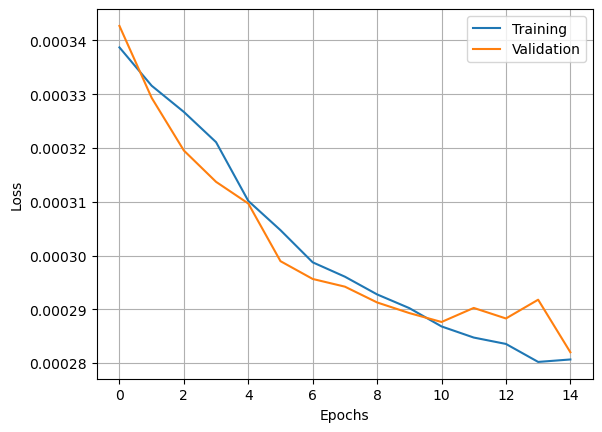

In [32]:
plot_losses(training_losses, validation_losses)

In [33]:
model_save_path = os.path.abspath(".") + "/model_60day.pt"
torch.save(model_60day, model_save_path)

In [34]:
model_60day = torch.load("model_60day.pt")

Scaling volumes: 100%|██████████| 120/120 [00:00<00:00, 4259.22it/s]


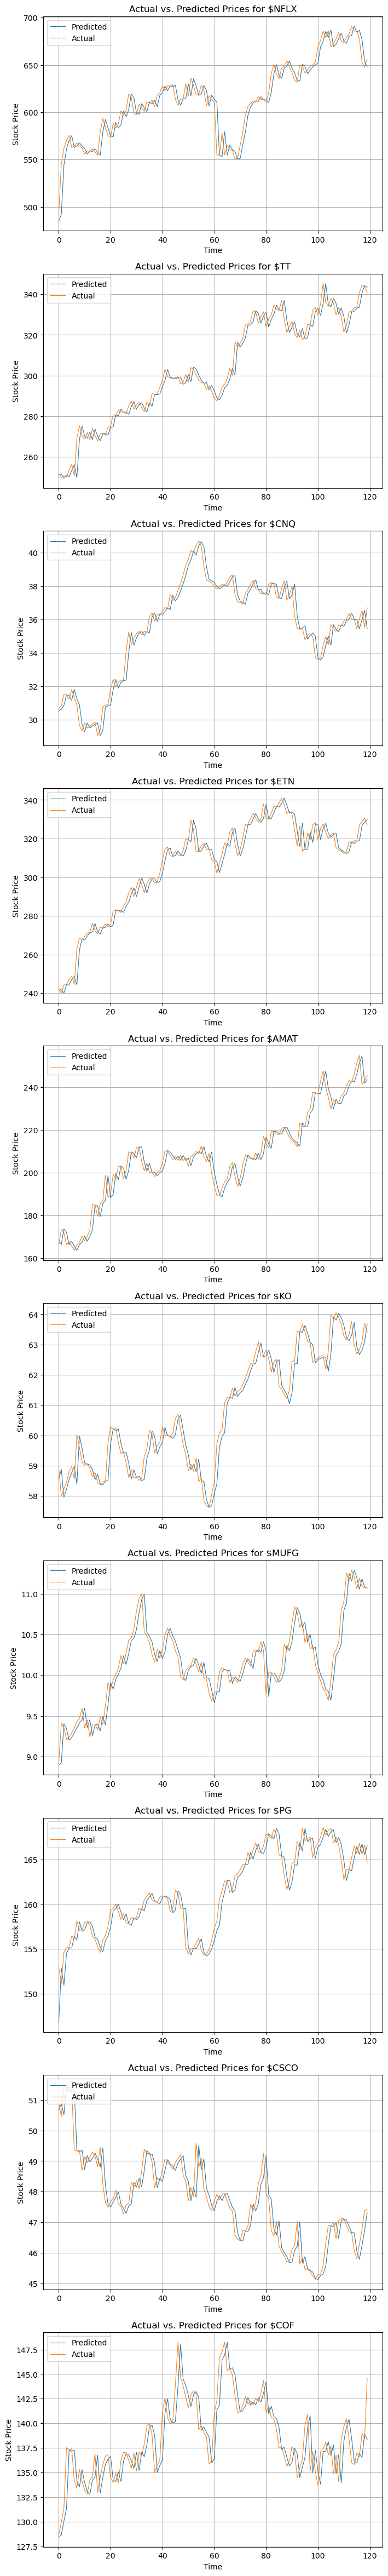

In [35]:
evaluate_non_sampled_symbols(model_60day, random.sample(not_sampled_symbols, 10), 14, start='2024-01-01', end='2024-07-15')

# 6. Discussion of Results

***

## 6.1 Ineffective performance of current architecture

***

From the results of the 14-day and 60-day models, it appears that the current kind of architecture is ineffective at providing insights into next-day closing prices. This is likely attributed to the erratic nature of stocks in relation to external news and world events.

The 14-day model with MSELoss had a strong tendency to produce optimistic estimates of next-day prices. Most of the time, it predicted a positive change in price in the next day. This could likely be attributed to the positive bias in the dataset, as stocks have historically risen. This issue could have also been exacerbated by the fact that the dataset consists of large- and mega-cap stocks, which are likely to have experienced growth throughout the dataset.

## 6.2 Shortcomings in methodology

***

The dataset used to train the above models only consisted of open, high, lose, close, and volume (OHLCV), though conventional trading techniques include indicators such as Exponential Moving Averages (EMAs), Moving Average Convergence Divergence (MACD), Relative Strength Index (RSI), Bollinger Bands, etc.

My initial belief was that OHLCV was sufficient for the deep models to learn some kind of resemblance to these indicators, but it seems that it was unable to leverage the limited data to produce insightful predictions.

Perhaps a more complex architecture with the same dataset could identify these patterns, but given the current design has already been limited by processing power, it is unreasonable to test that hypothesis in this project.

# 7. Adjustments in Methodology

***

## 7.1 Introducing Derived Features
***

### 7.1.1 EMA (8-, 13-, 21-day EMAs)

### 7.1.2 MACD

### 7.1.3 RSI

### 7.1.4 VWAP

## 7.2 Larger Dataset (Longer Time Period)

***

A 10-year time period can easily be collected using yfinance. However, this will require adjustments to our data processing methods.

Currently, data processing uses tensors, which require homogeneous dimensions. However, some stocks may not have the same amount of data.

Data will be initially processed via lists before being turned into a tensor of sequences.



# 8. New Data Processing

Indices:

0. Close
1. Volume
2. 8-day EMA
3. 13-day EMA
4. 21-day EMA
5. MACD Line (Moving Average Convergence/Divergence)
6. Signal Line
7. MACD Histogram Line
8. RSI (Relative Strength Index)

In [21]:
def get_data(symbols: list[str], start_date=None, end_date=None) -> list[StockData]:
    """
    Updated get_data function: returns a list of tensors
    instead of a full tensor
    (this is because stock data is no longer guaranteed uniform shape)
    """
    data = []
    for symbol in tqdm(symbols, desc="Retrieving symbols"):
        stock_data = database.get_stock_data(symbol, 
                                             fields=("open", "close", "high", "low", "volume"),
                                             start_date=start_date, end_date=end_date)
        if stock_data == None:
            continue
        else:
            data.append(stockdata_to_tensor(stock_data))
    
    return data

def stockdata_to_tensor(stock_data: StockData) -> torch.tensor:
    return torch.tensor(list(zip(*stock_data)), dtype=torch.float32)

In [13]:
def convert_open_close_to_log_returns(data: list[torch.tensor]) -> list[torch.tensor]:
    """
    Normalizes the open and close data by mapping them to log returns:
    
    Return_t = ln(current_price / previous_price)
    """
    open_prices = data[:,:,0]
    close_prices = data[:,:,1]
    open_log_returns = torch.log(open_prices[:, 1:] / open_prices[:, :-1])
    close_log_returns = torch.log(close_prices[:, 1:] / close_prices[:, :-1])
    
    # Pad array in the front with 0
    # this is to maintain consistent shape
    open_log_returns = torch.nn.functional.pad(open_log_returns, (1,0), 'constant', 0)
    close_log_returns = torch.nn.functional.pad(close_log_returns, (1,0), 'constant', 0)
    
    data[:,:,0] = open_log_returns
    data[:,:,1] = close_log_returns
    
    return data
    
def transform_data(data: torch.tensor) -> torch.tensor:
    data = convert_open_close_to_log_returns(data)
    
    return data[:,1:] # Remove the first day because of padding in first element from log returns
    

## 8.1 Adding Derived Features

In [79]:
def remove_high_low(x: torch.Tensor) -> torch.Tensor:
    return [torch.cat((elem[:,1:2], elem[:,4:]), dim=1) for elem in x]


def calculate_sma(prices: torch.tensor, period_length: int) -> torch.Tensor:
    """
    Calculates a Simple Moving Average for the first period
    """
    return torch.mean(prices[:period_length])


def calculate_ema(prices: torch.tensor, period_length: int) -> torch.Tensor:
    """
    Calculates EMA with a smoothing constant of 2
    """
    sma = calculate_sma(prices, period_length)
    ema_values = [sma]
    
    multiplier = 2 / (period_length + 1)
    
    for price in prices[period_length:]:
        ema_previous = ema_values[-1]
        ema_today = (price - ema_previous) * multiplier + ema_previous
        ema_values.append(ema_today)
        
    return torch.tensor(ema_values,dtype=torch.float32)


def add_emas_to_data(data: list[torch.Tensor], period_lengths: tuple[int]) -> list[torch.Tensor]:
    """
    Given the dataset, for each stock, calculate the EMAs (Exponential Moving Averages)
    on the closing prices and append it to the dataset.
    """
    new_data = []
    max_period_length = max(period_lengths)
    for stock_data in tqdm(data, desc="Deriving EMAs"):
        for period_length in period_lengths:
            ema = calculate_ema(stock_data.T[1], period_length)
            stock_data = append_column(stock_data, (ema,))
            
        new_data.append(stock_data[max_period_length:])
        
    # Remove all possible padded elements from the data
    return new_data


def add_macd_to_data(data: list[torch.Tensor]) -> list[torch.Tensor]:
    """
    Given the dataset, for each stock, calculate the MACD (Moving Average Convergence/Divergence)
    on the closing prices and append it to the dataset.
    """
    new_data = []
    for stock_data in tqdm(data, desc="Deriving MACD"):
        macd_line = calculate_macd_line(stock_data.T[1])
        signal_line = calculate_ema(macd_line, 9)
        macd_line = macd_line[8:]
        
        macd_histogram = macd_line - signal_line
        data_offset_length = stock_data.shape[0] - macd_histogram.shape[0]
        stock_data = append_column(stock_data, (macd_line, signal_line, macd_histogram))
        
        new_data.append(stock_data[data_offset_length:])
    return new_data
        
        
def calculate_macd_line(prices: torch.Tensor) -> torch.Tensor:
    """
    Calculates the MACD Line by computing the difference between the
    12-day EMA and 26-day EMA
    """
    ema_12 = calculate_ema(prices, 12)
    ema_26 = calculate_ema(prices, 26)
    
    # Shift 26-day EMA to match 12-day EMA
    ema_12 = ema_12[14:]
    
    # MACD Line = difference between 12-day and 26-day EMAs
    macd_line = ema_12 - ema_26
    
    return macd_line


def add_rsi_to_data(data: list[torch.Tensor], period_length: int) -> list[torch.Tensor]:
    """
    Calculates and appends the RSI to each stock's tensor.
    """
    new_data = []
    for stock_data in tqdm(data, desc="Deriving RSIs"):
        deltas = torch.diff(stock_data.T[1])
        
        gains = torch.max(deltas, torch.tensor(0))
        losses = torch.max(-deltas, torch.tensor(0))
        
        avg_gain = torch.zeros(len(deltas))
        avg_loss = torch.zeros(len(deltas))
        
        avg_gain[period_length-1] = torch.mean(gains[:period_length])
        avg_loss[period_length-1] = torch.mean(losses[:period_length])
        
        for i in range(period_length, len(deltas)):
            avg_gain[i] = (avg_gain[i-1] * (period_length-1) + gains[i]) / period_length
            avg_loss[i] = (avg_loss[i-1] * (period_length-1) + losses[i]) / period_length
            
        rs = avg_gain / avg_loss
        
        rsi = 100 - (100 / (1+rs))
        
        
        stock_data = append_column(stock_data, [rsi])[14:]
        new_data.append(stock_data)
    return new_data


def append_column(tensor: torch.Tensor, new_columns: tuple[torch.Tensor]) -> torch.Tensor:
    """
    Given a new column, pads the new_column to match the shape of tensor
    before applying torch.cat(...) to append the column to the data
    """
    
    for new_column in new_columns:
        padding_size = tensor.shape[0] - new_column.shape[0]
        padding = torch.zeros(padding_size, dtype=new_column.dtype)
        new_column = torch.cat((padding, new_column))
        
        tensor = torch.cat((tensor, new_column.unsqueeze(1)), dim=1)
    
    return tensor

def add_derived_features(data: list[torch.Tensor]) -> list[torch.Tensor]:
    """
    Condensed function that combines all of the above.
    """
    data = remove_high_low(data)
    data = add_emas_to_data(data, [8,13,21])
    data = add_macd_to_data(data)
    data = add_rsi_to_data(data, 14)
    return data

## 8.2 Normalizing/Standardizing Data

In [80]:
all_symbols = database.get_all_symbols()
sampled_symbols = random.sample(all_symbols, 5)
data = get_data(sampled_symbols, end_date="2023-01-01")
closing_prices = [torch.clone(x[:, 1]) for x in data]
data = add_derived_features(data)

Retrieving symbols: 100%|██████████| 5/5 [00:00<00:00, 117.32it/s]


torch.Size([2130, 5])
torch.Size([2130, 2])


Deriving EMAs: 100%|██████████| 5/5 [00:00<00:00, 13.67it/s]


torch.Size([2109, 5])


Deriving RSIs: 100%|██████████| 5/5 [00:00<00:00, 12.99it/s]


### 8.2.1 Closing Prices

In [55]:
def convert_close_to_log_returns(data: list[torch.Tensor]) -> list[torch.Tensor]:
    """
    Creates log returns between successive close prices 
    for each stock's price history.
    """
    for i in tqdm(range(len(data)), desc="Converting Close Prices to Log Returns"):
        stock_data = data[i]
        close_prices = stock_data.T[0]
        
        log_returns = torch.log(close_prices[1:] / close_prices[:-1])
        log_returns = torch.cat((torch.tensor([0]), log_returns)) # Pad the first element for shape consistency
        
        data[i].T[0] = log_returns
        data[i] = data[i][1:] # Cut off the first element due to padding
    
    return data

### 8.2.2 EMAs

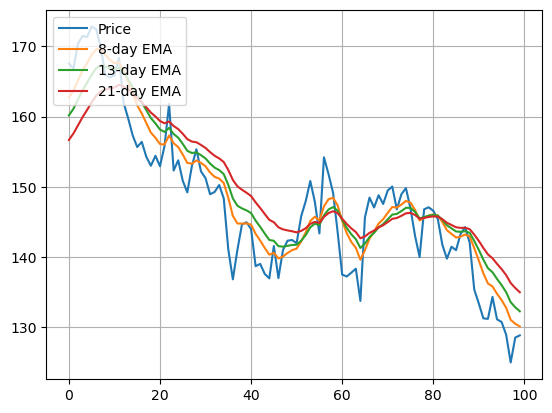

In [8]:
plt.clf()

plt.plot(data[0].T[1][-100:], label="Price")
plt.plot(data[0].T[3][-100:], label="8-day EMA")
plt.plot(data[0].T[4][-100:], label="13-day EMA")
plt.plot(data[0].T[5][-100:], label="21-day EMA")
plt.legend(loc="upper left")
plt.grid(True)
plt.show()

### 8.2.3 MACD

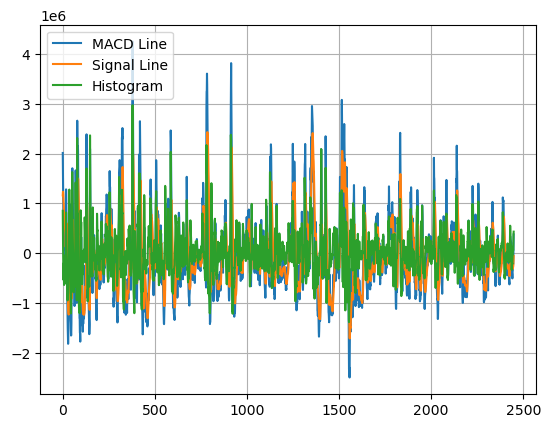

In [73]:
plt.clf()

plt.plot(data[0].T[5], label="MACD Line")
plt.plot(data[0].T[6], label="Signal Line")
plt.plot(data[0].T[7], label="Histogram")
plt.legend(loc="upper left")
plt.grid(True)

The data can show some heavy skew. It may make sense to normalize the data in batches (e.g., within intervals).

A local z-score normalization that assumes a pre-normalization mean of 0 benefits from:

- **Preserving the original mean of 0**
  - Since these measures oscillate around 0, it is important that the normalization captures this mean of 0 even if a given interval does not contain 0.
- **Scaling based on variability**
  - We are rescaling the data based on the variance of an interval's values. This aims to keep the data more approximately identically distributed across different stocks and their time periods.
- **Adaptability to local volatility**
  - The local normalization adapts to changse in volatility over time, which is beneficial for short-term prediction.

In [76]:
def normalize_macd(sequences: torch.Tensor) -> torch.Tensor:
    """
    Normalizes the MACD line, Signal line, and Histogram line,
    offset by the mean (see above)
    """
    for i in tqdm(range(len(sequences)), desc="Normalizing MACD Sequences"):
        sequence = sequences[i]
        
        # Take the st. deviation of each feature within each sequence
        # NOTE: the constant multiples attached at the ends are
        #   purely empirical to soft bound the values within roughly (-1, 1).
        # This is because LSTMs generally perform better with small values
        macd_std = np.std(sequence.T[5]) * 8
        signal_std = np.std(sequence.T[6]) * 8
        hist_std = np.std(sequence.T[7]) * 3
        
        sequence.T[5] = sequence.T[5] / macd_std
        sequence.T[6] = sequence.T[6] / signal_std
        sequence.T[7] = sequence.T[7] / hist_std

Normalizing MACD Sequences: 100%|██████████| 4838/4838 [00:00<00:00, 9390.66it/s]


BSX


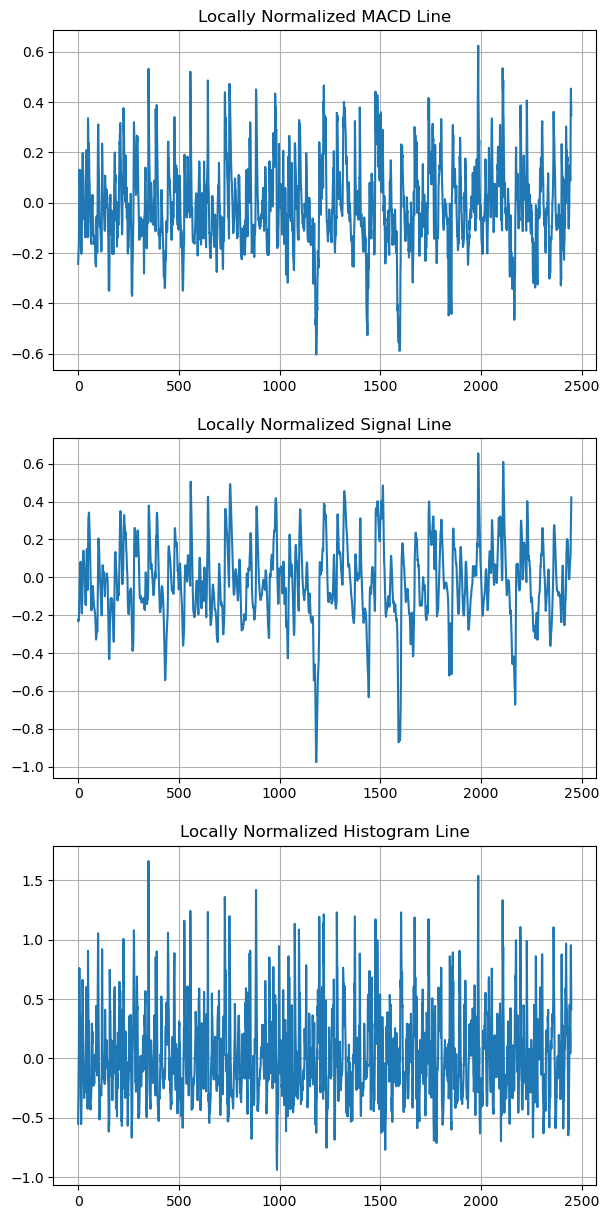

In [72]:
sampled_symbols = random.sample(all_symbols, 2)
data = get_data(sampled_symbols)
data = add_derived_features(data)
closing_prices = [torch.clone(x.T[0]) for x in data]
data = convert_close_to_log_returns(data)
dataset = StockPriceDataset(data, closing_prices, 30)
normalize_macd(dataset.sequences)
new_macd_line = []
new_signal_line = []
new_histogram_line = []
for i in range(len(data[0])):
    new_macd_line.append(dataset.sequences[i][-1][5])
    new_signal_line.append(dataset.sequences[i][-1][6])
    new_histogram_line.append(dataset.sequences[i][-1][7])
    
print(sampled_symbols[0])

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(7, 15))
axes[0].grid(True)
axes[1].grid(True)
axes[2].grid(True)
axes[0].plot(new_macd_line)
axes[0].set_title("Locally Normalized MACD Line")
axes[1].plot(new_signal_line)
axes[1].set_title("Locally Normalized Signal Line")
axes[2].plot(new_histogram_line)
axes[2].set_title("Locally Normalized Histogram Line")

plt.show()

We can observe that the data has been successfully rescaled to a consistent range.

### 8.2.4 Volumes

In [ ]:
def rescale_volumes(sequences: torch.Tensor) -> torch.Tensor:
    

In [ ]:
data